# Quasi-Static Time Series (QSTS) Simulation

In ANDES, QSTS can be done when there is no dynamic models in the system.
Then the time-domain simulation (TDS) is a series of steady-state AC power flow.

Along with model `TimeSeries`, voltage profiles under generation and load fluctuations
can be assessed more efficiently compared to full-order electro-mechanical transient
simulation.

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import andes

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(20)

We add a sample TimeSeries file to mimic the active load fluctuation.

In [4]:
data = {
    "t": list(range(1, 20)),
    "p": list(0.076 + 0.005 * i for i in range(19)),
    "q": [0.016] * 19,
}

df = pd.DataFrame(data)
df.to_excel("./pqts0.xlsx", sheet_name="PQTS", index=False)

`s0` is a case with only power flow models.

For comparison, `s1` that has dynamic models is also simulated.

In [5]:
s0 = andes.load(andes.get_case('ieee14/ieee14.raw'),
                default_config=True,
                setup=False,
                no_output=True,
                )
s1 = andes.load(andes.get_case('ieee14/ieee14.raw'),
                addfile = andes.get_case('ieee14/ieee14.dyr'),
                default_config=True,
                setup=False,
                no_output=True,
                )

s1.Toggle.set(src='u', attr='v',
              idx=['Toggle_1', 'Toggle_2'], value=[0, 0])

for ss in [s0, s1]:
    
    ss.add('TimeSeries',
            param_dict={
                'idx': 1,
                'name': 'TimeSeries_1',
                'path': os.getcwd() + '/pqts0.xlsx',
                'sheet': 'PQTS',
                'fields': 'p,q',
                'tkey': 't',
                'model': 'PQ',
                'dev': 'PQ_4',
                'dests': 'Ppf,Qpf',
            })

    ss.setup()

    # use constant power model for PQ
    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0

    ss.TDS.config.no_tqdm = True

Working directory: "/Users/hcui7/repos/andes/examples/demonstration"


> Loaded generated Python code in "/Users/hcui7/.andes/pycode".


Generated code for <PQ> is stale.


Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/hcui7/.andes/pycode"


> Reloaded generated Python code of module "pycode".


Generated numerical code for 1 models in 0.2131 seconds.


Parsing input file "/Users/hcui7/repos/andes/andes/cases/ieee14/ieee14.raw"...


  IEEE 14 BUS TEST CASE


  03/06/14 CONTO           100.0  1962 W


Input file parsed in 0.0064 seconds.


Working directory: "/Users/hcui7/repos/andes/examples/demonstration"


> Reloaded generated Python code of module "pycode".


Generated code for <PQ> is stale.


Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/hcui7/.andes/pycode"


> Reloaded generated Python code of module "pycode".


Generated numerical code for 1 models in 0.0915 seconds.


Parsing input file "/Users/hcui7/repos/andes/andes/cases/ieee14/ieee14.raw"...


  IEEE 14 BUS TEST CASE


  03/06/14 CONTO           100.0  1962 W


Input file parsed in 0.0061 seconds.


Parsing additional file "/Users/hcui7/repos/andes/andes/cases/ieee14/ieee14.dyr"...


Addfile parsed in 0.0532 seconds.


Read timeseries data from "/Users/hcui7/repos/andes/examples/demonstration/pqts0.xlsx"


System internal structure set up in 0.0701 seconds.


Read timeseries data from "/Users/hcui7/repos/andes/examples/demonstration/pqts0.xlsx"


IEEEST <IEEEST_1> added BusFreq <BusFreq_1> linked to bus <3.0>


ST2CUT <ST2CUT_2> added BusFreq <BusFreq_2> linked to bus <1.0>


ST2CUT <ST2CUT_3> added BusFreq <BusFreq_3> linked to bus <2.0>


System internal structure set up in 0.0189 seconds.


In [6]:
for ss in [s0, s1]:
    ss.PFlow.run()

-> System connectivity check results:


  No islanded bus detected.


  System is interconnected.


  Each island has a slack bus correctly defined and enabled.



-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method


Power flow initialized in 0.0021 seconds.


0: |F(x)| = 0.5605182134


1: |F(x)| = 0.006202200332


2: |F(x)| = 5.819382827e-06


3: |F(x)| = 6.957087684e-12


Converged in 4 iterations in 0.0022 seconds.


-> System connectivity check results:


  No islanded bus detected.


  System is interconnected.


  Each island has a slack bus correctly defined and enabled.



-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method


Power flow initialized in 0.0020 seconds.


0: |F(x)| = 0.5605182134


1: |F(x)| = 0.006202200332


2: |F(x)| = 5.819382827e-06


3: |F(x)| = 6.957087684e-12


Converged in 4 iterations in 0.0020 seconds.


We can see the QSTS runs much faster than the electro-mechanical transient simulation.

In [7]:
for ss in [s0, s1]:
    ss.TDS.run()

Initialization for dynamics completed in 0.0074 seconds.


Initialization was successful.


No differential equation detected.


Simulation to t=20.00 sec completed in 0.1315 seconds.


Initialization for dynamics completed in 0.0219 seconds.


Initialization was successful.


Simulation to t=20.00 sec completed in 0.7855 seconds.


In [8]:
stg_idx = s0.StaticGen.get_all_idxes()
gen_bus = s0.StaticGen.get(src='bus', attr='v', idx=stg_idx)
load_bus = [b for b in s0.Bus.idx.v if b not in gen_bus]

Since in the case file there is no voltage compensator (this is
usually not the case in real-world systems),
the voltage at load bus drops more significantly in electro-mechanical
transient simulation than in QSTS.

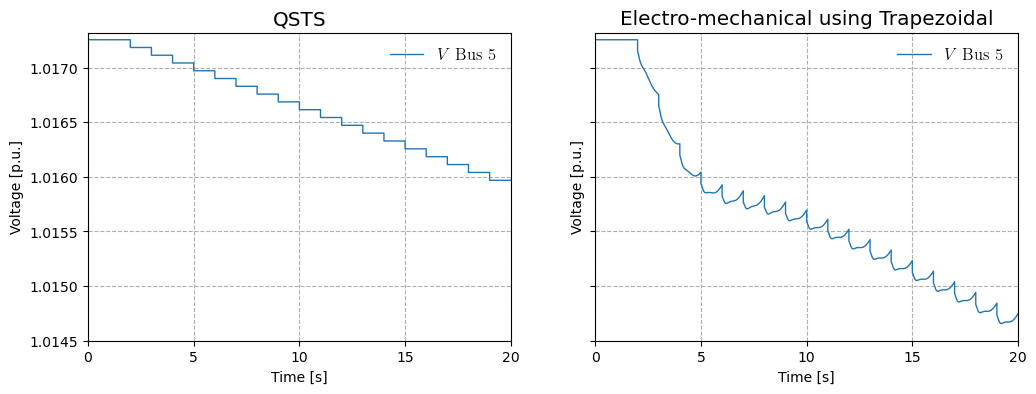

In [9]:
fig, ax = plt.subplots(1, 2,
                       figsize=(12, 4),
                       sharey=True)

a_bus_to_plot = s0.Bus.idx2uid(load_bus)[1]

_ = s0.TDS.plt.plot(s0.Bus.v,
                    a=a_bus_to_plot,
                    title='QSTS',
                    ylabel='Voltage [p.u.]',
                    ymin=1.0145,
                    show=False, grid=True,
                    fig=fig, ax=ax[0],)

_ = s1.TDS.plt.plot(s1.Bus.v,
                    a=a_bus_to_plot,
                    title='Electro-mechanical using Trapezoidal',
                    ylabel='Voltage [p.u.]',
                    show=False, grid=True,
                    fig=fig, ax=ax[1])

In [10]:
os.remove("./pqts0.xlsx")